In [1]:
import numpy as np
from numpy import linalg as LA
from scipy.optimize import linear_sum_assignment
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import networkx as nx

In [1]:
from graph_matching_p import GM_methods

In [2]:
%%latex 
Linear assignment solves:
$$ \min_{\Pi\in\mathcal{P}}\sum_{ij}C_{ij}\Pi_{ij}=\max_{\Pi}Tr(C\Pi^T)$$
where $C$ is a cost matrix, or 
$$\max_{\Pi\in\mathcal{P}}\sum_{ij}S_{ij}\Pi_{ij}=\max_{\Pi} Tr(S\Pi^T)$$
where $S$ is a similarity matrix and $\mathcal{P}$ is the set of permutation matrices.

<IPython.core.display.Latex object>

In [2]:
#Max Linear Assigment, using a similarity matrix. Returns a permutation matrix
def lin_assign(X):
    row_assign,col_assign = linear_sum_assignment(-X)
    w = np.empty(len(row_assign), dtype=int)
    w[:] = 1
    conn_matrix = csr_matrix((w, (row_assign, col_assign)), shape=(len(row_assign), len(col_assign)), dtype=int)
    return conn_matrix

In [3]:
%%latex
Grampa algorithm:

Similarity matrix 
$$\hat{X}=\sum_{ij}w(i,j)u_iu^T_i \mathbb{1} v_jv^T_j$$
with weights $$w(i,j)=\frac{1}{(\lambda_i-\mu_j)^2+\eta^2}$$

Then solves linear assignment with similarity $S=\hat{X}$

<IPython.core.display.Latex object>

In [4]:
#Grampa algorithm, from "Spectral Graph Matching and Regularized Quadratic Relaxations I" by Z.Fan, C.Mao, J.Xu, Y.Wu
def Grampa(A,B,eta):
    n = len(A[0,:])
    Lambda, U = LA.eig(A); Lambda=np.real(Lambda);U=np.real(U)
    Mu,V = LA.eig(B);Mu=np.real(Mu);V=np.real(V)
    coeff = 1 / (np.subtract.outer(Lambda,Mu)**2 + eta**2)
    #print(coeff.shape)
    coeff = coeff* np.matmul(np.matmul(U.T, np.ones((n,n))), V)
    X= np.matmul(np.matmul(U , coeff), V.T)
    
    # Rounding by linear assignment 
    Per_mat=lin_assign(X)
    return Per_mat


In [5]:
%%latex
Umeyama algorithm: Similarity matrix
$$\hat{X}=\sum_{i}|u_i||v_i|^T$$
Then solves linear assignment with similarity $S=\hat{X}$

<IPython.core.display.Latex object>

In [6]:
#Umeyama's algorithm 
def Umeyama(A,B):
    n=len(A[0,:])
    Lambda, U = LA.eig(A)
    Mu,V = LA.eig(B)
    idx = Lambda.argsort()[::-1]   
    Lamba_sorted = Lambda[idx]
    U_sorted = U[:,idx]
    idx = Mu.argsort()[::-1]   
    Mu_sorted = Mu[idx]
    V_sorted = V[:,idx]
    X=np.matmul(np.abs(U_sorted),np.transpose(np.abs(V_sorted)))
    
    # Rounding by linear assignment 
    Per_mat=lin_assign(X)
    return Per_mat
    
    

In [7]:
%%latex
EigenAlign algorithm: similarity in the vectorized form $[\hat{X}]$ is the eigenvector associated to the largest eigenvalue of $B\otimes A$, that is:
        $$[\hat{X}]=\operatorname{arg}\max_{\|y\|\leq 1}y B\otimes A y^T$$
LowRank algorithm: similarity matrix is:
        $$\hat{X}_s=\sum^k_{i=1}(s_i\lambda_i\mu_i)u_iv^T_i$$ for some $s_i\in\{-1,1\}$. 
        Then solves Linear Assigment with similarity $S=\hat{X}$.
        Alternatively we can solve directly:$$\max_{s_i\in\{-1,1\},\Pi\in\mathcal{P}}Tr(\hat{X}_s\Pi^T)$$

<IPython.core.display.Latex object>

In [9]:
#EigenAlign algorithm, from "Spectral Alignment of Graphs" by S.Feizi, G.Quon, M.Recamonde-Mendoza, M.Médard, M.Kellis, A.Jadbabaie
def EigenAlign(A,B):
    n=len(A[0,:])
    K=np.kron(B,A)
    Lambda, U=LA.eig(K)
    U_max=np.real(U[:,np.argmax(Lambda)])
    #X=np.reshape(U_max,(n,n)).T
    X=np.reshape(U_max,(n,n)).T
    #print(X)
    
    # Rounding by linear assignment
    Per_mat=lin_assign(np.abs(X))
    #Per_mat=lin_assign(X)
    return Per_mat

#LowRank algorithm, same reference.

def LowRank(A,B,k):
    n=len(A[0,:])
    Lambda, U = LA.eig(A)
    Mu,V = LA.eig(B)
    idx = Lambda.argsort()[::-1]   
    Lamba_sorted = Lambda[idx]
    U_sorted = U[:,idx]
    idx = Mu.argsort()[::-1]   
    Mu_sorted = Mu[idx]
    V_sorted = V[:,idx]
    X=np.matmul(np.abs(U_sorted[:,0:k]),np.transpose(np.abs(V_sorted[:,0:k])))
    ###Alternatively, define an array of signs 's' of lenght k
    #X=np.matmul(np.matmul(U_sorted[0,0:k],s),np.transpose(V_sorted[:,0:k]))
    
    # Rounding by linear assignment 
    Per_mat=lin_assign(X)
    return Per_mat
    

In [ ]:
#TopEigenvec


In [10]:
#Isorank algorithm, taken from  "Global alignment of multiple protein interaction networks with application to functional orthology detection" by R. Singh, J. Xu, B. Berger. 
#this version is based on the implementation by S. Zhang in https://github.com/sizhang92/FINAL-network-alignment-KDD16/blob/master/IsoRank.m  

#Here the matrix H is a prior similarity between nodes of both graphs
#the algorihtm is essentially PPR on the product graph
def IsoRank(A,B,H,alpha,maxiter,tol):
    n = len(A[0,:])
    A_nor=A/A.sum(axis=1)[:,None]
    B_nor=B/B.sum(axis=1)[:,None]
    A_nor[np.isnan(A_nor)]=0
    B_nor[np.isnan(B_nor)]=0
    X=(1/n**2)*np.ones((n,n))
    
    for iter in range(maxiter):
        previous=X
        X = alpha *np.matmul(np.matmul( B_nor.T, X), A_nor) + (1-alpha) * H
        delta = LA.norm(X- previous)
        
        if delta < tol: 
            break
    
    # Rounding by linear assignment 
    Per_mat=lin_assign(X)
    return Per_mat
    


In [3]:
#Some random graphs and random matrices models 
from scipy.spatial import distance
def ER(n,prob):
    Ber=np.random.binomial(n=1,p=prob,size=(n,n))
    UT=np.triu(Ber)
    return UT+UT.T-2*np.diag(np.diag(Ber))

def GaussianWigner(n,var):
    Gau=np.random.normal(loc=0,scale=np.sqrt(var),size=(n,n))
    UT=np.triu(Gau)
    return UT+UT.T

def Corr_Gaussian(n,var, sigma):
    #generate a ground true permutation
    true_perm=np.random.permutation(np.arange(n)) 
    P_rnd=perm_mat(true_perm)
    A=GaussianWigner(n,var)
    C=GaussianWigner(n,var)
    B=np.sqrt(1-sigma**2)*A+sigma*C
    #shuffle rows and columns of matrix B
    aux=B[:,true_perm]
    B=aux[true_perm,:]
    return A,B,P_rnd
   


def Corr_ER(n,prob,s):
    q=prob*(1-s)/(1-prob)
    A=ER(n,prob)
    B1=np.random.binomial(n=1,p=s,size=(n,n))
    B1[A==0]=0
    B2=np.random.binomial(n=1,p=q,size=(n,n))
    B2[A==1]=0
    B=B1+B2
    B=B-np.diag(np.diag(B))
    return A,B

def RGG(n,d,tau):#generate random geometric graphs
    rnd_points_sphere=sample_spherical(n,d)
    gram=rnd_points_sphere@rnd_points_sphere.T
    adjacency=np.copy(gram)
    adjacency[adjacency<=tau]=0
    return gram,adjacency

def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

def Corr_RGG(n,d,tau,sigma):
    #generate a ground true permutation
    true_perm=np.random.permutation(np.arange(n)) 
    P_rnd=perm_mat(true_perm)
    rnd_points_gaussian_A=np.random.normal(loc=0,scale=1/np.sqrt(d),size=(n,d))# corresponds to the first cloud of points cloud_A
    rnd_points_gaussian_B=np.random.normal(loc=0,scale=1/np.sqrt(d),size=(n,d))
    cloud_B=np.sqrt(1-sigma**2)*rnd_points_gaussian_A[true_perm]+sigma*rnd_points_gaussian_B
    DistA=distance.cdist(rnd_points_gaussian_A, rnd_points_gaussian_A, 'euclidean')
    DistB=distance.cdist(cloud_B, cloud_B, 'euclidean')
    GraphA=np.copy(DistA)
    GraphA[GraphA<=tau]=1
    GraphA[GraphA>tau]=0
    GraphA=GraphA-np.diag(np.diag(GraphA))
    GraphB=np.copy(DistB)
    GraphB[GraphB<=tau]=1
    GraphB[GraphB>tau]=0
    GraphB=GraphB-np.diag(np.diag(GraphB))
    return DistA, DistB, GraphA, GraphB,P_rnd

#def RGG(n,d,tau):
#put different models...    


In [7]:
#some useful functions, anything beyond the models and main algorithms 

#Objective fnct for the QAP formulation of GM
def GM_objective_fnct(A,B,perm):
    return np.trace(np.matmul(np.matmul(np.matmul(A,perm),B),perm.T))

#Objective fnct convex formulation of GM
def GM_objective_fnct_conv(A,B,perm):
    return LA.norm(A@perm-perm@B,'fro')

#Square part of the convex obj. fnct. of GM
def GM_objective_quad(A,B,perm):
    return GM_objective_fnct_conv(A,B,perm)+2*GM_objective_fnct(A,B,perm)

#Comparison between two permutations
def mismatch_frac(perm1,perm2):
    return 0.5*np.sum(np.abs(perm1-perm2))/len(perm1[0,:])

#from assignment sequence to permutation matrix
def perm_mat(perm):
    w = np.empty(len(perm), dtype=int)
    w[:] = 1
    permu=csr_matrix((w, (perm, np.arange(len(perm)))), shape=(len(perm), len(perm)), dtype=int).A
    return permu


In [13]:
#example with correlated Wigner Matrices
eta=0.2
size=50
noise_lev=0
low_rank=3
A,B,true_perm=Corr_Gaussian(size,1,noise_lev)#generate the two matrices
#true_perm=np.random.permutation(np.arange(len(B[0,:]))) #generate a ground true permutation
#we apply the algorihtms 
#per1=Grampa(A,B,eta).A
#per2=EigenAlign(A,B).A
#per3=Umeyama(A,B).A
#per4=LowRank(A,B,low_rank).A
#per5=IsoRank(A,B,np.zeros((size,size)),1,200,0.01)
#true_perm_mat=perm_mat(true_perm)
print(GM_objective_fnct(A,B,true_perm))
print(GM_objective_fnct_conv(A,B,true_perm))
print(GM_objective_quad(A,B,true_perm))



2674.7230258142913
0.0
5349.446051628583


In [14]:

mont=25
noise_lev=np.arange(0,1,0.05)
l=np.arange(100,800,200)
rat=np.zeros((len(l),len(noise_lev),mont))
ob1=np.zeros((len(l),len(noise_lev),mont))
ob2=np.zeros((len(l),len(noise_lev),mont))
#print(l)
for i in range(len(l)):
    for j in range(len(noise_lev)):
        for k in range(mont):
            A,B,true_perm=Corr_Gaussian(l[i],1,noise_lev[j])
            ob1[i,j,k]=GM_objective_fnct(A,B,true_perm)
            ob2[i,j,k]=GM_objective_quad(A,B,true_perm)
            rat[i,j,k]=ob1[i,j,k]/ob2[i,j,k]
m_rat=np.mean(rat,axis=1)
print(m_rat)

    
    

[[0.49793097 0.49790724 0.49788011 0.49783812 0.49787786 0.49785599
  0.49790134 0.49787052 0.49786636 0.49793721 0.49789801 0.49793141
  0.4978544  0.49790432 0.49788862 0.49789654 0.49784599 0.49792257
  0.49790824 0.49786966 0.49785479 0.49788675 0.49795422 0.49785777
  0.49784568]
 [0.49929    0.499286   0.49928705 0.49928814 0.49928768 0.49928767
  0.49929381 0.49928344 0.49928777 0.49929102 0.49928937 0.49928657
  0.49929247 0.49928511 0.49928513 0.49928038 0.49929022 0.49928445
  0.49928606 0.49928422 0.49928852 0.49928592 0.49928506 0.49928444
  0.49929223]
 [0.49957093 0.49957008 0.49957144 0.49957115 0.49957233 0.49956909
  0.49957089 0.49956939 0.49957097 0.49957134 0.49957002 0.49957326
  0.4995721  0.49956856 0.49957122 0.49957082 0.49957241 0.49957087
  0.4995714  0.49957133 0.49957154 0.49957129 0.49957124 0.49956998
  0.49956988]
 [0.49969294 0.49969485 0.49969354 0.49969313 0.4996931  0.49969229
  0.49969372 0.49969352 0.49969227 0.49969271 0.49969261 0.49969274
  0.49

In [37]:
print(ob1[:,:,1])
#print(np.mean(rat,axis=0))
#print(np.mean(rat,axis=1))
#print(np.mean(rat,axis=2))



IndexError: invalid index to scalar variable.

In [15]:
#here we print the value of the obj. fnct for the GM problem for all algorithms
print('objective fnct value: ', 'Grampa: '+str(GM_objective_fnct(A,B,per1)),
      'EigenAlign: '+str(GM_objective_fnct(A,B,per2)),'Umeyama: '+str(GM_objective_fnct(A,B,per3)),
      'LowRank: '+str(GM_objective_fnct(A,B,per4)),'Ground true perm: '+str(GM_objective_fnct(A,B,true_perm_mat)),
      sep='\n')


objective fnct value: 
Grampa: 897.8981884144506
EigenAlign: 32.920688483739674
Umeyama: 897.8981884144506
LowRank: 897.8981884144506
Ground true perm: 897.8981884144506


In [87]:
#here we print the mismatch fraction for each algorithm
print('mismatch fraction (compared with the ground true permutation): ','Grampa: '+str(mismatch_frac(per1,true_perm_mat)),
      'EigenAlign: '+ str(mismatch_frac(per2,true_perm_mat)),'Umeyama: '+str(mismatch_frac(per3,true_perm_mat)),
      'LowRank: '+str(mismatch_frac(per4,true_perm_mat)),sep='\n'
     )


NameError: name 'per1' is not defined

In [17]:
#Example with correlated Wigner, for different levels of noise 
eta=0.2
size=20
low_rank=3
noise=np.arange(0,1,0.1)# from 0 to 1 steps 0.1
repeat=10 #average over repeat number of times
match_frac_array=np.zeros((4,len(noise)))
for k in range(len(noise)):
    m1=0;m2=0;m3=0;m4=0
    for t in range(repeat):
        A,B=Corr_Gaussian(size,1,noise[k])#generate the two matrices
        true_perm=np.random.permutation(np.arange(len(B[0,:]))) #generate a ground true permutation
        true_perm_mat=perm_mat(true_perm)
        aux=B[:,true_perm] #shuffle rows and columns of matrix B
        B=aux[true_perm,:]
        #we apply the algorihtms 
        per1=Grampa(A,B,eta).A; per2=EigenAlign(A,B).A; per3=Umeyama(A,B).A; per4=LowRank(A,B,low_rank).A
        m1=m1+(1-mismatch_frac(per1,true_perm_mat)); m2=m2+(1-mismatch_frac(per2,true_perm_mat));
        m3=m3+(1-mismatch_frac(per3,true_perm_mat));m4=m4+(1-mismatch_frac(per4,true_perm_mat))
    
    match_frac_array[:,k]=(1/repeat)*np.array([m1,m2,m3,m4])

    


Text(0, 0.5, 'matched fraction')

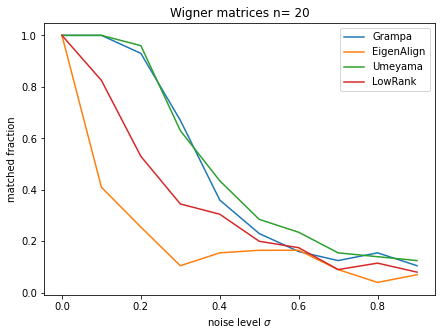

In [18]:
#plot the result...
plt.figure(figsize=(7,5))
plt.plot(noise, match_frac_array.T)
plt.legend(['Grampa','EigenAlign','Umeyama','LowRank'])
plt.title('Wigner matrices n= '+str(size))
plt.xlabel('noise level '+r'$\sigma$')
plt.ylabel('matched fraction')

In [19]:
#Example with correlated Erdös-Rényi graphs
eta=0.2
size=30 #number of nodes of each graph
corr_lev=0.95  #the correlation parameter 's' 
p=0.2 #edge probability in ER graph
A,B=Corr_ER(size,p,corr_lev) #generate the two adj. matrices
#print(A,B)
true_perm=np.random.permutation(np.arange(len(B[0,:]))) #generate a ground true permutation
aux=B[:,true_perm] #shuffle rows and columns of matrix B
B=aux[true_perm,:]
#we apply the algorihtms 
per1=Grampa(A,B,eta).A
per2=EigenAlign(A,B).A
per3=Umeyama(A,B).A
per4=LowRank(A,B,3).A
#per5=IsoRank(A,B,np.zeros((size,size)),1,200,0.01)
true_perm_mat=perm_mat(true_perm)

In [22]:
#print some results

print('objective fnct value: ', 'Grampa: '+str(GM_objective_fnct(A,B,per1)),
      'EigenAlign: '+str(GM_objective_fnct(A,B,per2)),'Umeyama: '+str(GM_objective_fnct(A,B,per3)),
      'LowRank: '+str(GM_objective_fnct(A,B,per4)),'Ground true perm: '+str(GM_objective_fnct(A,B,true_perm_mat)),
      sep='\n')
print('-------------------------------------------------------------')
print('mismatch fraction (compared with the ground true permutation): ','Grampa: '+str(mismatch_frac(per1,true_perm_mat)),
      'EigenAlign: '+ str(mismatch_frac(per2,true_perm_mat)),'Umeyama: '+str(mismatch_frac(per3,true_perm_mat)),
      'LowRank: '+str(mismatch_frac(per4,true_perm_mat)),sep='\n'
     )

objective fnct value: 
Grampa: 103
EigenAlign: 59
Umeyama: 124
LowRank: 60
Ground true perm: 186
-------------------------------------------------------------
mismatch fraction (compared with the ground true permutation): 
Grampa: 0.3333333333333333
EigenAlign: 0.8333333333333334
Umeyama: 0.26666666666666666
LowRank: 0.8333333333333334


In [24]:
import trustregion

NetworkXError: random_state_index is incorrect

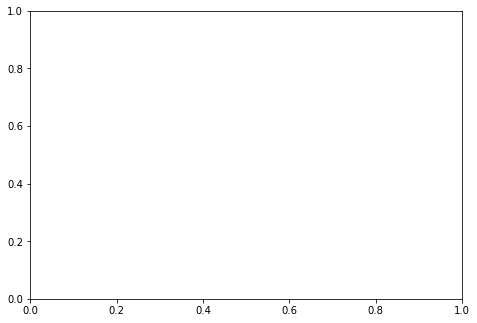

In [85]:
#sample corr_RGG
n=1000
sigma=0.1
d=3
tau=1
DA,DB,GA,GB,P_rnd=Corr_RGG(n,d,tau,sigma)

In [86]:
per3=Umeyama(GA,GB).A
mismatch_frac(per3,P_rnd)


0.982

In [15]:
import projection_simplex
from projection_simplex import projection_simplex_bisection, projection_simplex_sort, projection_simplex_pivot

def simplex_GD(A,B,in_point,gamma,maxiter=100):
    n=np.shape(A)[1]
    A2=np.matmul(A,A)#A@A
    B2=np.matmul(B,B)#B@B
    X=np.copy(in_point.T)
    X=np.reshape(X,n**2,order='F')
    X=projection_simplex_sort(X)
    X=np.reshape(X,(n,n),order='F')
    for i in range(maxiter):
        grad=-2*np.matmul(np.matmul(A,X),B)+np.matmul(A2,X)+np.matmul(X,B2)+0.2*LA.norm(X,'fro')
        X=X-gamma*grad
        X=np.reshape(X,n**2,order='F')
        #print(np.shape(X))
        X=projection_simplex_sort(X,n)
        #print(np.shape(X))
        X=np.reshape(X,(n,n),order='F')
    Per_mat=lin_assign(X)
    return Per_mat
    

    

In [196]:
eta=0.2
size=100
noise_lev=0
low_rank=3
A,B,true_perm=Corr_Gaussian(size,1/size,noise_lev)#generate the two matrices
#true_perm=np.random.permutation(np.arange(len(B[0,:]))) #generate a ground true permutation
#we apply the algorihtms 
#per1=Grampa(A,B,eta).A
#per2=EigenAlign(A,B).A
#per3=Umeyama(A,B).A
#per4=LowRank(A,B,low_rank).A
#per5=IsoRank(A,B,np.zeros((size,size)),1,200,0.01)
#true_perm_mat=perm_mat(true_perm)
print(GM_objective_fnct(A,B,true_perm))
print(GM_objective_fnct_conv(A,B,true_perm))
print(GM_objective_quad(A,B,true_perm))


105.29852422400991
0.0
210.59704844801982


In [197]:
n=np.shape(A)[1]
#gam=(1/(np.log(500)*1.5))
gam=0.1
per_simplex=simplex_GD(A,B,(1/n)*np.ones((n,n)),gam,100)
per_grampa=Grampa(A,B,0.2)



In [198]:
print(mismatch_frac(per_simplex.A,true_perm))
print(mismatch_frac(per_grampa.A,true_perm))


0.0
0.0


In [152]:
OO=np.random.standard_normal((10,10))
print(OO)
OO=np.reshape(OO,100, order='F')
print(OO)
OO=np.reshape(OO,(10,10),order='F')
print(OO)
OO=projection_simplex_pivot(np.reshape(OO,100))
print(OO)
OO=np.reshape(OO,(10,10))
print(OO)



[[-0.17386312  0.7402035  -0.36615653 -0.0523759  -0.41299474 -0.57468987
   0.59551732 -1.99385476  0.60983418 -1.0551458 ]
 [-0.54966269 -0.79406398 -1.7721922  -0.31482704 -0.56107251  0.10639902
   0.58330959  0.65807441  1.02666744  1.14934754]
 [-1.29787684  0.12229536 -1.88562042  0.44927547 -0.71636758 -0.76201369
   1.10308085 -1.32107402 -0.45072559 -2.09718169]
 [-0.18036807 -1.3828221  -1.0507617   1.21357591  0.46207051 -0.40251721
   0.69825618 -0.1292856   0.17959006 -0.93861011]
 [-1.0577081  -0.56142432  1.52741094 -0.13929397  1.75242902 -0.31832414
   0.5200161  -0.19420304 -1.82059584 -1.13003636]
 [-0.03304689 -1.46172295 -1.00090233 -1.44079746 -0.89833105  0.01334692
  -0.99781044 -1.15403448 -0.03663265  0.36162625]
 [ 0.14230583  0.56948492  0.75408427 -1.86792148  1.07234041  1.27260807
   1.49150884  0.50182459 -0.15650412  0.42019485]
 [-0.06495086  1.05255432  0.93804156  0.06072558 -1.4172199   0.72185201
   0.44224824 -0.18872134  1.76435772 -0.74242514]


In [99]:
import random
#PPM projected power method for the nonconvexfunction
def projected_power_method(A,B,init_point,maxiter=100):
    actual_point=init_point
    for i in range(maxiter):
        grad=(A@actual_point)@B
        actual_point=greedy_weighted_matching(grad,-2000)
    return actual_point
def greedy_weighted_matching(simil_matrix,thresh_param):
    n=np.shape(simil_matrix)[1]
    #shape=np.shape(simil_matrix)
    matching=np.zeros((n,n)) #initialize the permutation matrix 
    for i in range(n):
        ii=np.unravel_index(simil_matrix.argmax(),(n,n))
        matching[ii[0],ii[1]]=1
        simil_matrix[ii[0],:]=thresh_param*np.ones(n)
        simil_matrix[:,ii[1]]=thresh_param*np.ones(n)
        #simil_matrix[ii[0],:]=thresh_param*np.ones((1,n))
        #simil_matrix[:,ii[1]]=thresh_param*np.ones((n,1))
    return matching
def rnd_permutation_inNeighborhood(size,neigh_radius, reference_permutation): #creates a permutation in a Frobenius neighborhood (defined by neigh_radius) of reference_permutation
    permu=np.copy(reference_permutation)
    sampled_indices=random.sample(list(range(size)),k=neigh_radius)
    shuf_sampled_indices=np.array(sampled_indices)[np.array(list(random_derangement(neigh_radius)))]
    permu[:,np.array(shuf_sampled_indices)]=permu[:,sampled_indices]
    return permu
#generate random derangements, code was taken from https://stackoverflow.com/questions/25200220/generate-a-random-derangement-of-a-list, user georg
def random_derangement(n):
    while True:
        v = [i for i in range(n)]
        for j in range(n - 1, -1, -1):
            p = random.randint(0, j)
            if v[p] == j:
                break
            else:
                v[j], v[p] = v[p], v[j]
        else:
            if v[0] != 0:
                return tuple(v)




In [100]:
n=np.shape(A)[1]
initial_point= rnd_permutation_inNeighborhood(n,int(np.floor(n/5)),true_perm) #define init point
per_ppm=projected_power_method(A,B,initial_point,100)
print(mismatch_frac(per_ppm,true_perm))


0.0


In [11]:
A,B,true_perm=Corr_Gaussian(10,1/10,0.1)
np.shape(A)==np.shape(np.eye(5))

False